In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [89]:
# Laste poll-of-polls data
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [90]:
#df = df[2:]

In [91]:
df

,Mnd,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
0,Mars-25,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4
1,Februar-25,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
2,Januar-25,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
3,Desember-24,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5
4,November-24,18.7,22.4,22.0,9.0,6.6,3.1,5.1,3.4,5.9,3.8
...,...,...,...,...,...,...,...,...,...,...,...
202,Mai-08,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
203,April-08,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
204,Mars-08,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
205,Februar-08,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0


In [92]:
# tom dict for prediksjoner
predictions = {"Mnd": ["April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}

In [93]:
###for å kunne konvertere til dato datatype
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [94]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [95]:
df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-11-30,18.7,22.4,22.0,9.0,6.6,3.1,5.1,3.4,5.9,3.8
2024-12-31,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5
2025-01-31,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9


In [96]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.851558929258971, p-value: 0.3551808917906396
Hoyre ADF Statistic: -2.3543109644833855, p-value: 0.15504902650795538
Frp ADF Statistic: -1.7607237664465978, p-value: 0.4001281094923916
SV ADF Statistic: -1.242893094423126, p-value: 0.6548775422204279
Sp ADF Statistic: -1.550002222389858, p-value: 0.5086470859944946
KrF ADF Statistic: -1.8624202777280545, p-value: 0.34994094950786214
Venstre ADF Statistic: -2.8686853857617853, p-value: 0.04911252339005664
MDG ADF Statistic: -1.616623853088634, p-value: 0.4744997202738589
Rodt ADF Statistic: -0.791395187021204, p-value: 0.821636608064078
Andre ADF Statistic: -1.7123745230167027, p-value: 0.4247482927219784


In [97]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [98]:
df_diff

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-02-29,-0.3,0.1,1.3,-0.7,-0.2,-0.1,0.1,0.0,0.0,0.0
2008-03-31,-0.3,0.8,0.0,0.3,-0.3,-0.2,-0.3,0.0,-0.2,0.0
2008-04-30,0.3,-1.2,0.2,-0.5,-0.1,0.9,0.5,0.0,0.1,0.0
2008-05-31,-0.1,0.9,0.5,0.2,0.2,-0.8,-0.6,0.0,0.2,0.0
2008-06-30,-2.9,-0.2,3.0,0.2,-0.4,-0.1,-0.3,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-1.2,-1.0,1.7,0.2,0.8,-0.2,-0.4,-0.1,0.0,0.1
2024-12-31,-1.5,-1.2,3.4,0.4,-1.3,0.8,0.2,-0.3,-0.1,-0.3
2025-01-31,1.9,1.0,-1.3,-1.4,0.6,-0.5,-0.8,0.2,-0.2,0.4


In [99]:
# ADF test on each column of df_diff
for col in df_diff.columns:
    result = adfuller(df_diff[col])
    print(f'{col}: p-value={result[1]}')

Ap: p-value=4.083576930220192e-26
Hoyre: p-value=4.282460078179586e-12
Frp: p-value=5.345468821088279e-25
SV: p-value=1.8296501196692407e-22
Sp: p-value=4.578182476820814e-28
KrF: p-value=4.932924001089519e-25
Venstre: p-value=5.599425408706684e-26
MDG: p-value=3.5662777255942116e-29
Rodt: p-value=2.9793125723026415e-13
Andre: p-value=9.317143237591945e-30


In [100]:
model = VAR(df_diff)  
model_fitted = model.fit(maxlags=10,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Mar, 2025
Time:                     09:45:47
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    5.56562
Nobs:                     196.000    HQIC:                  -4.38835
Log likelihood:          -687.493    FPE:                4.09390e-05
AIC:                     -11.1595    Det(Omega_mle):     6.63408e-07
--------------------------------------------------------------------
Results for equation Ap
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.Ap              -1.571161         0.539710           -2.911           0.004
L1.Hoyre           -1.527407         0.541802           -2.819           0.005
L1.Frp             -1.696939         0.545637           -3.110         

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [101]:
# Compute R² for each party
r2_scores = {}
for party in df_diff.columns:
    r2_scores[party] = r2_score(df_diff[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.5218
R² for Hoyre: 0.5176
R² for Frp: 0.4989
R² for SV: 0.5776
R² for Sp: 0.4867
R² for KrF: 0.5957
R² for Venstre: 0.5544
R² for MDG: 0.5091
R² for Rodt: 0.5772
R² for Andre: 0.5849


In [102]:
# Compute MAE, MSE, RMSE, and MAPE for each party
mae_scores = {}
mse_scores = {}
rmse_scores = {}

for party in df_diff.columns:
    actual = df_diff[party].iloc[model_fitted.k_ar:]
    predicted = model_fitted.fittedvalues[party]
    
    mae_scores[party] = mean_absolute_error(actual, predicted)
    mse_scores[party] = mean_squared_error(actual, predicted)
    rmse_scores[party] = np.sqrt(mse_scores[party])  # RMSE

# Print MAE, MSE, RMSE, and MAPE values
for party in df_diff.columns:
    print(f"MAE for {party}: {mae_scores[party]:.4f}")
    print(f"MSE for {party}: {mse_scores[party]:.4f}")
    print(f"RMSE for {party}: {rmse_scores[party]:.4f}")


MAE for Ap: 0.7939
MSE for Ap: 1.0614
RMSE for Ap: 1.0302
MAE for Hoyre: 0.6963
MSE for Hoyre: 0.7888
RMSE for Hoyre: 0.8881
MAE for Frp: 0.6262
MSE for Frp: 0.6390
RMSE for Frp: 0.7994
MAE for SV: 0.2375
MSE for SV: 0.0883
RMSE for SV: 0.2972
MAE for Sp: 0.5028
MSE for Sp: 0.4215
RMSE for Sp: 0.6492
MAE for KrF: 0.1898
MSE for KrF: 0.0609
RMSE for KrF: 0.2468
MAE for Venstre: 0.2321
MSE for Venstre: 0.0841
RMSE for Venstre: 0.2899
MAE for MDG: 0.1927
MSE for MDG: 0.0604
RMSE for MDG: 0.2459
MAE for Rodt: 0.2460
MSE for Rodt: 0.0970
RMSE for Rodt: 0.3114
MAE for Andre: 0.2035
MSE for Andre: 0.0667
RMSE for Andre: 0.2582


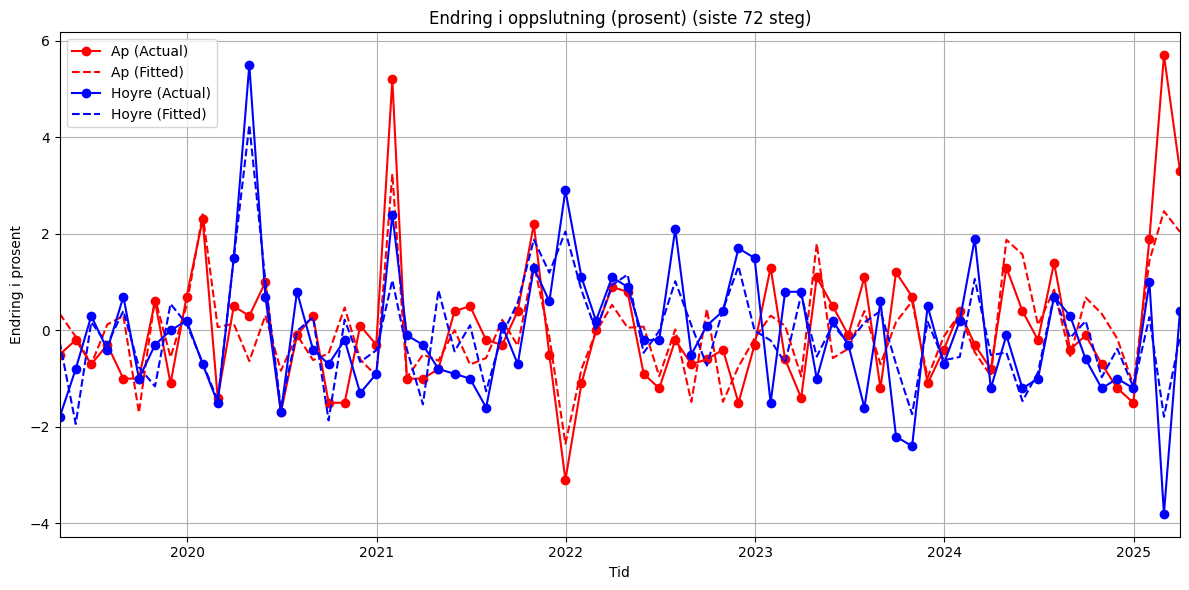

In [103]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
}

# Number of time steps to plot back in time
steps = 72

# Get fitted values (predicted changes in differenced scale)
fitted_values = model_fitted.fittedvalues[-steps:]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]

    # Extract actual data for the last 'steps' data points
    actual_data = df_diff[party].iloc[-steps:]
    
    # Plot actual data (last 'steps' points)
    plt.plot(df_diff.index[-steps:], actual_data, marker="o", color=color, label=f"{party} (Actual)")

    # Plot fitted values (dashed line)
    plt.plot(fitted_values.index, fitted_values[party], linestyle="dashed", color=color, label=f"{party} (Fitted)")

    # Calculate the R-squared value between actual and fitted values
    r2 = r2_score(actual_data, fitted_values[party])

    # Print the R-squared value on the plot
    #plt.text(0.9, 0.1, f"R²: {r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.xlim(df.index[-steps], df.index[-1])  # Set x-axis range to last 'steps' records
plt.xlabel("Tid")
plt.ylabel("Endring i prosent")
plt.title("Endring i oppslutning (prosent) (siste 72 steg)")

# Show the legend
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [104]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [105]:
steps = 6  # Number of steps to forecast
alpha = 0.50

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-04-30", periods=steps, freq='ME')

forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


In [106]:
# Get forecast covariance in differenced scale
forecast_cov_diff = model_fitted.forecast_cov(steps=steps)

# Initialize original scale covariance matrix
forecast_cov_original_scale = np.zeros_like(forecast_cov_diff)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov_original_scale[t] = np.sum(forecast_cov_diff[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_original_df = {t: pd.DataFrame(forecast_cov_original_scale[t], index=df.columns, columns=df.columns)
                            for t in range(steps)}


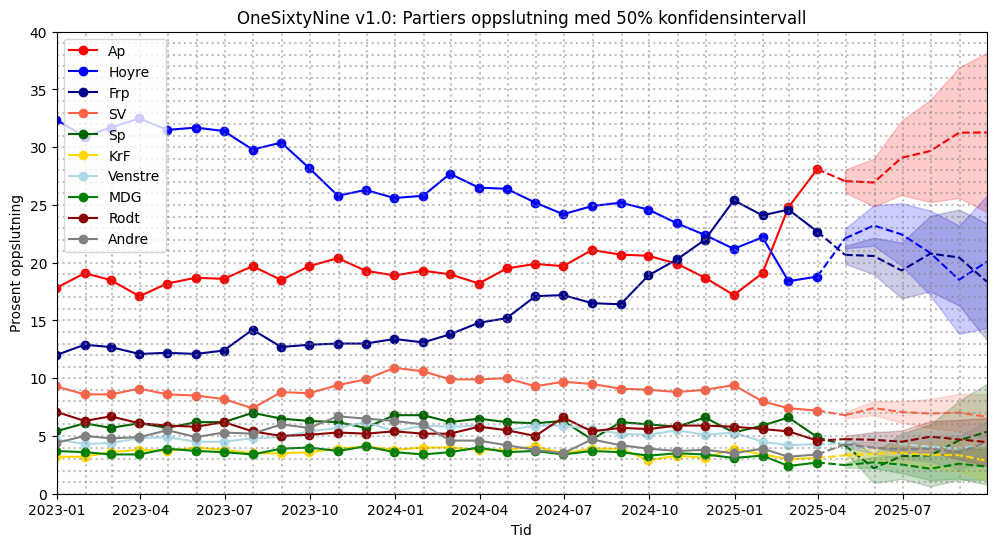

In [107]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    last_actual_date = df.index[-1]
    first_forecast_date = forecast_original_scale.index[0]
    last_actual_value = df[party].iloc[-1]
    first_forecast_value = forecast_original_scale[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2023-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v1.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [108]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-04-30,27.066109,22.105778,20.681700,6.795915,4.174079,3.318914,4.362663,2.480435,4.725446,4.269415
2025-05-31,26.943088,23.220354,20.584351,7.410022,2.210004,3.447851,4.818660,2.718560,4.672891,3.994147
2025-06-30,29.084417,22.455228,19.328699,7.075024,3.255335,3.536651,4.301424,2.524753,4.498470,3.825105
2025-07-31,29.676494,20.838950,20.790602,6.942792,3.315683,3.360234,4.075055,2.163351,4.939688,3.888209
2025-08-31,31.255744,18.523516,20.453387,7.027719,4.624079,3.339593,3.916585,2.594314,4.702582,3.583386
2025-09-30,31.277803,20.083846,18.354260,6.648491,5.360859,2.856474,4.276988,2.343029,4.470235,4.458841


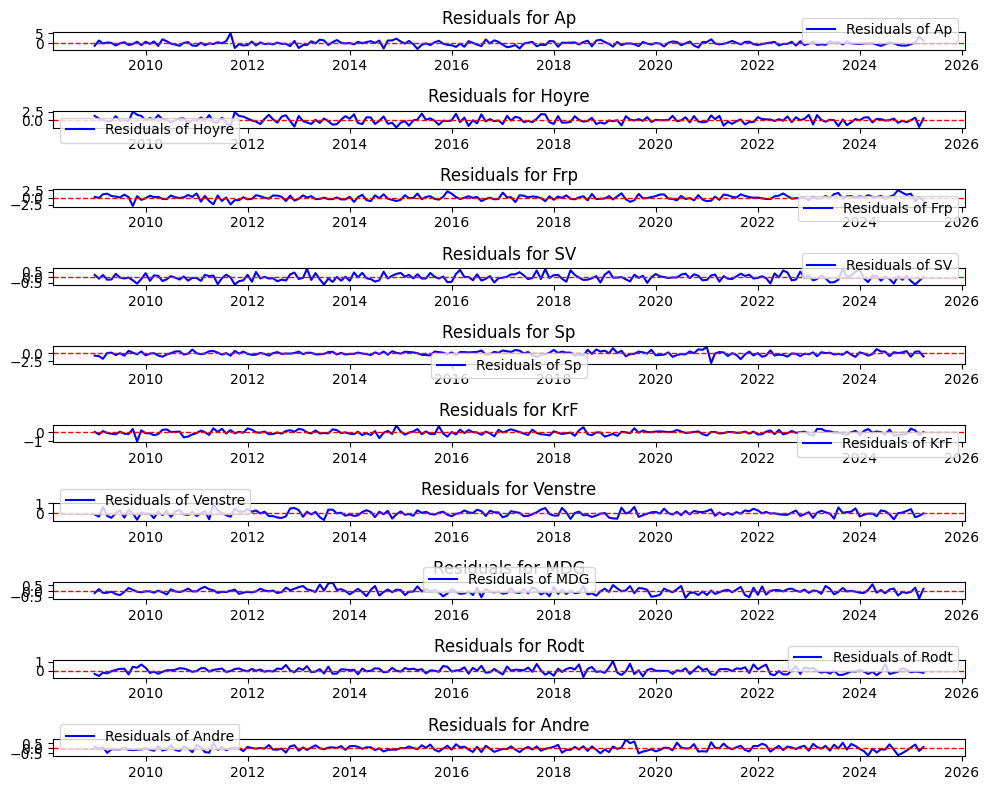

In [109]:
# Get residuals from the fitted model
residuals = model_fitted.resid  # Residuals for all variables

# Plot residuals for each variable
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 8))

for i, col in enumerate(residuals.columns):
    axes[i].plot(residuals.index, residuals[col], label=f"Residuals of {col}", color="blue")
    axes[i].axhline(y=0, linestyle="--", color="red", linewidth=1)
    axes[i].set_title(f"Residuals for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

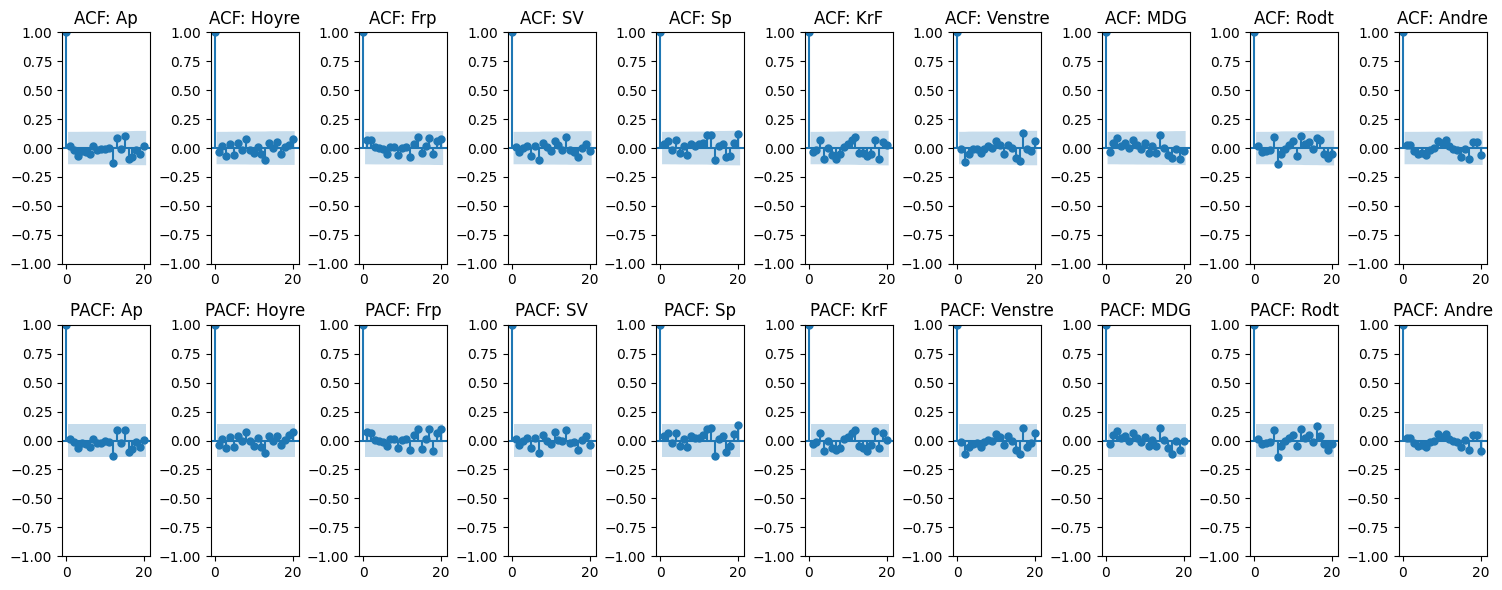

In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF for residuals of the first variable
fig, axes = plt.subplots(nrows=2, ncols=residuals.shape[1], figsize=(15, 6))

for i, col in enumerate(residuals.columns):
    plot_acf(residuals[col], ax=axes[0, i], lags=20, title=f"ACF: {col}")
    plot_pacf(residuals[col], ax=axes[1, i], lags=20, title=f"PACF: {col}")

plt.tight_layout()
plt.show()

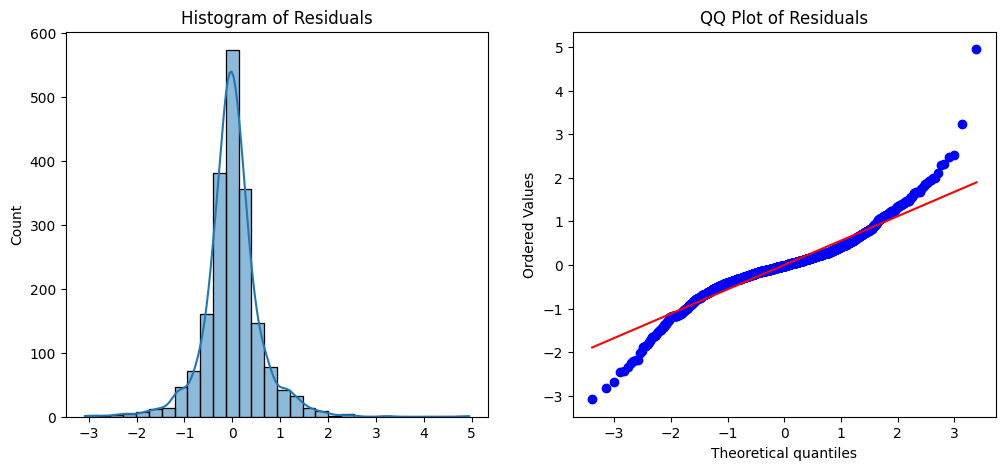

In [111]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(residuals.values.flatten(), kde=True, ax=axes[0], bins=30)
axes[0].set_title("Histogram of Residuals")

# QQ Plot
stats.probplot(residuals.values.flatten(), dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot of Residuals")

plt.show()


In [112]:
forecast_lower_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-04-30,26.073225,21.249846,19.911297,6.509501,3.548370,3.081062,4.083239,2.243489,4.425337,4.020561
2025-05-31,24.875860,21.465537,19.002350,6.805597,0.926012,2.929869,4.205494,2.236489,4.034873,3.468086
2025-06-30,25.859864,19.754556,16.915439,6.142390,1.285976,2.729053,3.345179,1.785619,3.513121,3.010131
2025-07-31,25.250853,17.158979,17.517560,5.677494,0.633598,2.245625,2.768020,1.158099,3.603448,2.765298
2025-08-31,25.609313,13.830629,16.300246,5.413481,1.211860,1.912793,2.250058,1.315338,3.002580,2.146208
2025-09-30,24.378253,14.352115,13.305218,4.672250,1.201616,1.110480,2.244656,0.784956,2.394728,2.702005


In [113]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-04-30,28.058993,22.961710,21.452102,7.082328,4.799787,3.556766,4.642087,2.717380,5.025555,4.518270
2025-05-31,29.010316,24.975171,22.166352,8.014447,3.493996,3.965832,5.431827,3.200630,5.310908,4.520208
2025-06-30,32.308971,25.155900,21.741958,8.007659,5.224695,4.344248,5.257669,3.263887,5.483819,4.640079
2025-07-31,34.102135,24.518921,24.063645,8.208090,5.997768,4.474843,5.382091,3.168603,6.275927,5.011121
2025-08-31,36.902174,23.216404,24.606528,8.641958,8.036298,4.766392,5.583112,3.873291,6.402585,5.020563
2025-09-30,38.177352,25.815577,23.403303,8.624733,9.520101,4.602468,6.309321,3.901102,6.545742,6.215677


In [114]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  31.277803  24.378253  38.177352
1    Hoyre  20.083846  14.352115  25.815577
2      Frp  18.354260  13.305218  23.403303
3       SV   6.648491   4.672250   8.624733
4       Sp   5.360859   1.201616   9.520101
5      KrF   2.856474   1.110480   4.602468
6  Venstre   4.276988   2.244656   6.309321
7      MDG   2.343029   0.784956   3.901102
8     Rodt   4.470235   2.394728   6.545742
9    Andre   4.458841   2.702005   6.215677


In [115]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-04-30,27.066109,22.105778,20.681700,6.795915,4.174079,3.318914,4.362663,2.480435,4.725446,4.269415
2025-05-31,26.943088,23.220354,20.584351,7.410022,2.210004,3.447851,4.818660,2.718560,4.672891,3.994147
2025-06-30,29.084417,22.455228,19.328699,7.075024,3.255335,3.536651,4.301424,2.524753,4.498470,3.825105
2025-07-31,29.676494,20.838950,20.790602,6.942792,3.315683,3.360234,4.075055,2.163351,4.939688,3.888209
2025-08-31,31.255744,18.523516,20.453387,7.027719,4.624079,3.339593,3.916585,2.594314,4.702582,3.583386
2025-09-30,31.277803,20.083846,18.354260,6.648491,5.360859,2.856474,4.276988,2.343029,4.470235,4.458841


In [116]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov_original_scale[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.7178


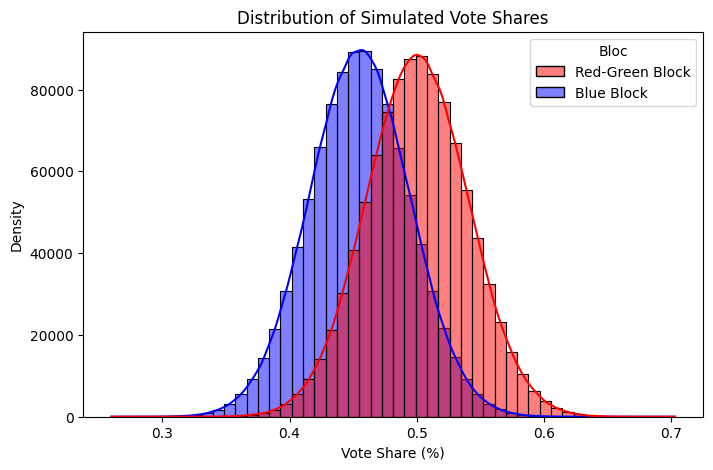

In [117]:
# Create a DataFrame with both red-green and blue votes
df_votes = pd.DataFrame({
    "Red-Green Block": red_green_votes,
    "Blue Block": blue_votes
})

# Melt the DataFrame for easier plotting
df_votes_melted = df_votes.melt(var_name="Bloc", value_name="Votes")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=df_votes_melted, x="Votes", hue="Bloc", kde=True, palette={"Red-Green Block": "red", "Blue Block": "blue"}, alpha=0.5, bins=50)
plt.xlabel("Vote Share (%)")
plt.ylabel("Density")
plt.title("Distribution of Simulated Vote Shares")
plt.show()


In [118]:
# Define party groupings
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Calculate sum columns for each bloc
forecast_original_scale["Red-Green Block"] = forecast_original_scale[red_green_parties].sum(axis=1)
forecast_lower_original_scale["Red-Green Block"] = forecast_lower_original_scale[red_green_parties].sum(axis=1)
forecast_upper_original_scale["Red-Green Block"] = forecast_upper_original_scale[red_green_parties].sum(axis=1)

forecast_original_scale["Blue Block"] = forecast_original_scale[blue_parties].sum(axis=1)
forecast_lower_original_scale["Blue Block"] = forecast_lower_original_scale[blue_parties].sum(axis=1)
forecast_upper_original_scale["Blue Block"] = forecast_upper_original_scale[blue_parties].sum(axis=1)


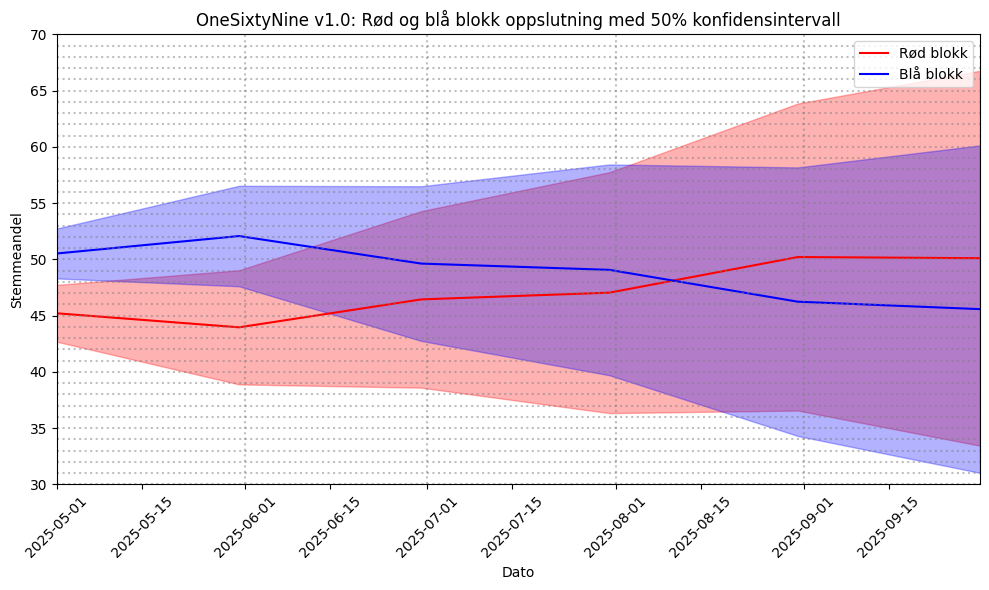

In [121]:
# Plot the red-green and blue block time series with confidence intervals
plt.figure(figsize=(10, 6))

# Plot Red-Green Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Red-Green Block", label="Rød blokk", color="red")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Red-Green Block"], 
                 forecast_upper_original_scale["Red-Green Block"], 
                 color="red", alpha=0.3)

# Plot Blue Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Blue Block", label="Blå blokk", color="blue")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Blue Block"], 
                 forecast_upper_original_scale["Blue Block"], 
                 color="blue", alpha=0.3)

dates = pd.date_range(start="2025-05-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(30, 70, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

# Customize the plot
plt.xlim(np.datetime64("2025-05-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(30,70)  # Manually set max date to Sept 2025
plt.title('OneSixtyNine v1.0: Rød og blå blokk oppslutning med 50% konfidensintervall')
plt.xlabel('Dato')
plt.ylabel('Stemmeandel')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
